In [1]:
import numpy as np

import os, imp

import matplotlib.pyplot as plt

from PIL import Image

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14,10)

%matplotlib inline

In [2]:
# Get the path to the lego directory
_package_path = '/home/sean/Insight/legos/'

# Load the image processing library
_ip_subpkg = 'image_processing'
_ip_module = 'image_processing.py'
ip         = imp.load_source(_ip_subpkg, _package_path+_ip_subpkg+'/'+_ip_module)

In [3]:
lego_dir = '/home/sean/Desktop/lego_images_bounding_raw/'

lego_file_list = os.listdir( lego_dir )

In [4]:
n_images = 3

min_false_image_mult = 4
max_false_image_mult = 10

min_false_image_resize = 0.9
max_false_image_resize = 1.5

min_solo_image_mult = 1.6
max_solo_image_mult = 2.0

rand_noise_avg_min = 100
rand_noise_avg_max = 200

rand_noise_std_min = 10
rand_noise_std_max = 50

min_n_images = 1
max_n_images = 4

big_counter = 0
out_img_counter = 0
out_box_list = {}

In [5]:
import random
import numpy     as np
import PIL.Image as Image
import matplotlib.patches as patches

def get_avg_background_color( inp_arr ):
    return ( 
                inp_arr[  0 ,  0 ] +  
                inp_arr[  0 , -1 ] +  
                inp_arr[ -1 ,  0 ] +  
                inp_arr[ -1 , -1 ] 
           ) / 4.

def get_pil_img_arr( img ):
    image_arr = np.array( img.getdata() )
    r_vals = image_arr[:,0].reshape( img.size[::-1] )
    g_vals = image_arr[:,1].reshape( img.size[::-1] )
    b_vals = image_arr[:,2].reshape( img.size[::-1] )
    return np.array( [r_vals,g_vals,b_vals] )


In [18]:
def embed_lego(
                lego_image_arr,
                min_false_image_mult,
                max_false_image_mult,
              ):
    
    # Generate random size of outer image, will flip if rand_flip==1
    rand_size = random.uniform( 
                                min_false_image_mult , 
                                max_false_image_mult , 
                              ) * np.array( lego_image_arr.shape[1:3] )
    
    # Generate the false image, set as full white
    false_image = np.ones( [3,int(rand_size[0]),int(rand_size[1])], dtype=int )    
    for i in range( 0 , 3 ):
        false_image[i] = false_image[i] * 255#avg_background_color[i]

    
    # Get new coordinates
    min_x = random.randint( 0, false_image.shape[1]-lego_image_arr.shape[1] - 2 )
    max_x = min_x + lego_image_arr.shape[1]
    min_y = random.randint( 0, false_image.shape[2]-lego_image_arr.shape[2] - 2 )
    max_y = min_y + lego_image_arr.shape[2]
    
    # Embed image
    for i in range( 0, 3 ):
        false_image[
                    i,
                    min_x:max_x,
                    min_y:max_y
                   ] = lego_image_arr[i]
    # Replace white with red... (leaves alpha values alone...)
    white_areas = (false_image[0] == 255) & (false_image[0] == 255) & (false_image[0] == 255)
    
    # Generate noise
    for rgb in range( 0, 3 ):
        noise_avg = random.uniform( 
                                    rand_noise_avg_min , 
                                    rand_noise_avg_max , 
                                  )
        noise_std = random.uniform( 
                                    rand_noise_avg_min , 
                                    rand_noise_avg_max , 
                                  )

        noise_arr = ( (
                        noise_std*np.random.randn( 
                                                    false_image[rgb].shape[0], 
                                                    false_image[rgb].shape[1] 
                                                  )+noise_avg
                      ).astype(int) 
                    )
    
        noise_arr[ noise_arr > 255 ] = 255
        noise_arr[ noise_arr <   0 ] =   0
        false_image[rgb][white_areas] = noise_arr[white_areas].copy()

        
    return false_image, {'x_min':min_x,'x_max':max_x,'y_min':min_y,'y_max':max_y}
    
    
def toss_lego (
                inp_img ,
                min_false_image_resize ,
                max_false_image_resize ,
              ):
    
    # np array
    inp_arr = get_pil_img_arr( inp_img )
    
    # Whether or not we will flip the image
    rand_flip = random.randint( 0, 1 )
    
    # Rotation, 0 0deg, 1 90deg, 2 180deg, 3 270deg
    rand_rot  = random.randint( 0, 3 )
    
    # Get amount we will resize embedded image by
    rand_resize = random.uniform( 
                                    min_false_image_resize , 
                                    max_false_image_resize , 
                                )
    
    # Resized to 
    resize_size = rand_resize * np.array( inp_arr.shape[1:3] )
    resize_size = [ int( resize_size[0] ) , int( resize_size[1]) ]
    
    
    # Copy original image, but resize it for variation
    inset_img = inp_img.resize( resize_size, Image.ANTIALIAS )    
    inset_arr = inp_arr
    
    
    # Flip the image across h axis
    if ( rand_flip ):
        new_arr = inset_arr.copy()
        for i in range( 0 , 3 ):
            new_arr[i,:,:] = ip.h_flip_array( inset_arr[i] )
        inset_arr = new_arr.copy()
    
    # Rotate the image
    if ( rand_rot != 0 ):
        new_arr = inset_arr.copy()
        for i in range( 0 , 3 ):
                new_arr[i,:,:] = np.rot90( inset_arr[i], rand_rot )
        inset_arr = new_arr.copy()
    
    return inset_arr


def embed_another_lego(
                        lego_img,
                        outer_img_arr,
                        min_false_image_resize ,
                        max_false_image_resize ,
                      ):
    
    # Move the lego around
    lego_arr = toss_lego( 
                        lego_img,
                        min_false_image_resize,
                        max_false_image_resize,
                     )
    

    # Actually, non white areas
    white_areas = ( (lego_arr[0] != 255) & (lego_arr[1] != 255) & (lego_arr[2] != 255) )

    # Get new coordinates
    min_x = random.randint( 0, outer_img_arr.shape[1]-lego_arr.shape[1] - 2 )
    max_x = min_x + lego_arr.shape[1]
    min_y = random.randint( 0, outer_img_arr.shape[2]-lego_arr.shape[2] - 2 )
    max_y = min_y + lego_arr.shape[2]
    
    # Embed image
    for i in range( 0, 3 ):
        embed_slice = outer_img_arr[
                        i,
                       min_x:max_x,
                        min_y:max_y
                     ]
        embed_slice[white_areas] = lego_arr[i][white_areas]
        outer_img_arr[
                        i,
                        min_x:max_x,
                        min_y:max_y
                     ] = embed_slice

    return outer_img_arr, {'x_min':min_x,'x_max':max_x,'y_min':min_y,'y_max':max_y}


Below here, begin creating false images

In [6]:
lego_file_name = lego_dir + lego_file_list[0]

lego_image_base = Image.open( lego_file_name )

Now, need to get background color

In [7]:
lego_image_base_arr = get_pil_img_arr( lego_image_base )

r_vals = lego_image_base_arr[0]
g_vals = lego_image_base_arr[1]
b_vals = lego_image_base_arr[2]


image_rgb_arr = np.array( [ r_vals, g_vals, b_vals ] )

In [8]:
background_images = os.listdir( '/home/sean/Pictures/Me' )

All need:
    Rotation
    Translation
    Noise

Options:
    Minor rescaling, 1 lego
    Single lego in image
    Other legos in image

Minor rescaling

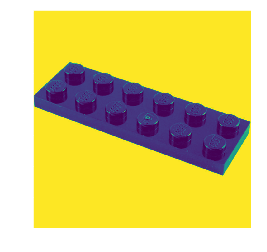

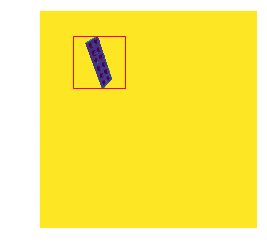

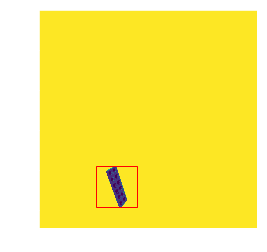

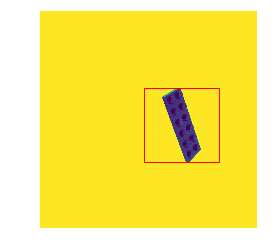

In [38]:
plt.imshow( image_rgb_arr[0] )
plt.show()



# Loop over number of reproduced images we will make
for false_image_i in range( 0 , n_images ):

    lego_arr = toss_lego( 
                            lego_image_base,
                            min_false_image_resize,
                            max_false_image_resize,
                         )
    
    img_arr, bound_dict = embed_lego(
                                lego_arr ,
                                min_false_image_mult   ,
                                max_false_image_mult   ,
                           )
    
    min_x = bound_dict['x_min'] 
    max_x = bound_dict['x_max']
    min_y = bound_dict['y_min'] 
    max_y = bound_dict['y_max']
    
    fig, ax = plt.subplots(1)
    rect = patches.Rectangle((min_y,min_x),max_x-min_x,max_y-min_y,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

    
    out_box_list[str(big_counter)] = [min_x,min_y,max_x,max_y]
    


    big_counter = big_counter + 1
    

    ax.imshow( img_arr[0] )
    plt.show()

Add multiple images

Generate main image stuff

Then select out non-white pixels

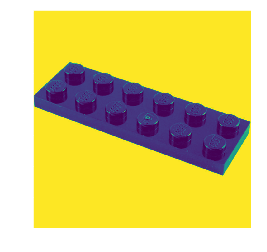

3
rotating  3


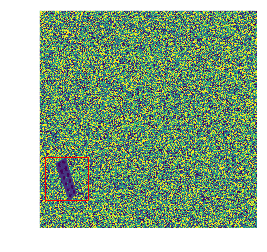

2
rotating  2


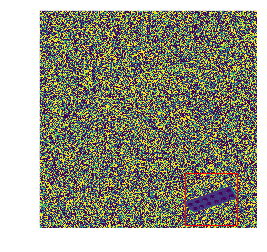

2
rotating  2


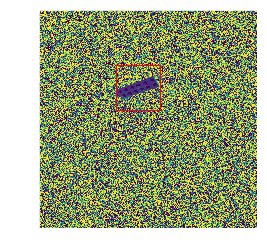

In [17]:
plt.imshow( image_rgb_arr[0] )
plt.show()

n_images = 3
n_add_img = 0

# Loop over number of reproduced images we will make
for false_image_i in range( 0 , n_images ):
    fig, ax = plt.subplots(1)

    lego_arr = toss_lego( 
                            lego_image_base,
                            min_false_image_resize,
                            max_false_image_resize,
                         )
    
    img_arr, bound_dict = embed_lego(
                                lego_arr ,
                                min_false_image_mult   ,
                                max_false_image_mult   ,
                           )
    
    min_x = bound_dict['x_min'] 
    max_x = bound_dict['x_max']
    min_y = bound_dict['y_min'] 
    max_y = bound_dict['y_max']
    
    orig_rect = patches.Rectangle((min_y,min_x),max_x-min_x,max_y-min_y,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes

    ax.imshow( img_arr[0] )
    
    out_box_list[str(big_counter)] = [min_x,min_y,max_x,max_y]
    
    bound_list = []
    for add_img in range( 0, n_add_img ):
        img_arr, bound_b = embed_another_lego( 
                                                lego_image_base,
                                                img_arr,
                                                min_false_image_resize,
                                                max_false_image_resize,
                                              )
        ax.imshow( img_arr[0] )
    
        print bound_b
        min_x = bound_b['x_min'] 
        max_x = bound_b['x_max']
        min_y = bound_b['y_min'] 
        max_y = bound_b['y_max']
        out_box_list[str(big_counter)+'_'+str(add_img)] = [min_x,min_y,max_x,max_y]

        rect = patches.Rectangle((min_y,min_x),max_x-min_x,max_y-min_y,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    ax.add_patch(orig_rect)

    big_counter = big_counter + 1
    

    plt.show()

In [138]:
false_image

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]])

In [154]:
bar = np.swapaxes( false_image, 0, 2 )##np.zeros( [false_image.shape[2],false_image.shape[1],false_image.shape[0]] )
#for         i in range( 0 , false_image.shape[2] ):
#    for     j in range( 0 , false_image.shape[1] ):
#        for k in range ( 0 , false_image.shape[0] ):
#            bar[i,j,k] = false_image[k,j,i]

foo = Image.fromarray( bar.astype('uint8'), 'RGB' )

In [19]:
lego_dir         = '/home/sean/Desktop/lego_downloads_reduced/'
lego_subdir_list = os.listdir( lego_dir )
#lego_file_list = os.listdir( lego_dir )


In [25]:
for subdir in lego_subdir_list:
    
    current_dir = lego_dir+subdir
    lego_file_list = os.listdir( current_dir )

    for lego_file in lego_file_list:
        
        use_this_file = False
        try:
            lego_file_name = current_dir +'/'+ lego_file
            lego_image_base = Image.open( lego_file_name )
            use_this_file = True
        except:
            print 'Unable to fully utilize ', lego_file_name
    
        if use_this_file:
            # Loop over number of reproduced images we will make
#            for false_image_i in range( 0 , n_images ):
            
#            out_file.save( out_path )
#            big_counter = big_counter + 1
#        print 'Successfully wrote files for '+lego_file
#    except:
#        print 'Unable to work with '+lego_file
            
#with open('output_info.txt','w') as f:
#    for i in range( 0, big_counter ):
#        try:
#            out_file = out_box_list['file'+str(i)]
#            out_bound= out_box_list['bounds'+str(i)]
#            f.write('\''+out_file+'\','+str(out_bound)+',\'lego\'\n')
#        except:
#            pass

/home/sean/Desktop/lego_downloads_reduced/brick_corner_1x2x2
/home/sean/Desktop/lego_downloads_reduced/brick_corner_1x2x2/8. 235724.jpg
Unable to fully utilize  /home/sean/Desktop/lego_downloads_reduced/brick_corner_1x2x2/8. 235724.jpg


In [ ]:
import random
import numpy     as np
import PIL.Image as Image
import matplotlib.patches as patches
import numpy as np

import os, imp

import matplotlib.pyplot as plt

from PIL import Image

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14,10)

%matplotlib inline


# Get the path to the lego directory
_package_path = '/home/sean/Insight/legos/'

# Load the image processing library
_ip_subpkg = 'image_processing'
_ip_module = 'image_processing.py'
ip         = imp.load_source(_ip_subpkg, _package_path+_ip_subpkg+'/'+_ip_module)


lego_dir         = '/home/sean/Desktop/lego_images_bounding_labeled/'
lego_subdir_list = os.listdir( lego_dir )


# CHANGE THESE
n_rescale_images = 3 # Number of solo big resized images
n_mult_images    = 5 # Number of multiple lego images 
n_add_img        = 5 # Number to add to an image


min_solo_image_resize = 0.5 # How to resize the embedded image
max_solo_image_resize = 1.5

min_solo_image_mult = 2.0 # How much  bigger outer image is than embedded
max_solo_image_mult = 2.5

min_false_image_resize = 0.25 # ''
max_false_image_resize = 1.25

min_multi_image_mult = 6.0 # ''
max_multi_image_mult = 12.0



# Noise follows normal distribution
rand_noise_avg_min = 100
rand_noise_avg_max = 200

rand_noise_std_min = 10
rand_noise_std_max = 15

# Maximum size of image
max_pix = 3000


big_counter = 0
out_img_counter = 0
out_box_list = {}


out_dir = '/home/sean/Desktop/lego_images_bounding_box_dirty/'
out_box_info = 'out_info.txt'


def get_avg_background_color( inp_arr ):
    return ( 
                inp_arr[  0 ,  0 ] +  
                inp_arr[  0 , -1 ] +  
                inp_arr[ -1 ,  0 ] +  
                inp_arr[ -1 , -1 ] 
           ) / 4.

def get_pil_img_arr( img ):
    image_arr = np.array( img.getdata() )
    r_vals = image_arr[:,0].reshape( img.size[::-1] )
    g_vals = image_arr[:,1].reshape( img.size[::-1] )
    b_vals = image_arr[:,2].reshape( img.size[::-1] )
    return np.array( [r_vals,g_vals,b_vals] )

def embed_lego(
                lego_image_arr,
                min_false_image_mult,
                max_false_image_mult,
              ):
    
    # Generate random size of outer image, will flip if rand_flip==1
    rand_size = random.uniform( 
                                min_false_image_mult , 
                                max_false_image_mult , 
                              ) * np.array( lego_image_arr.shape[1:3] )
    
    # Generate the false image, set as full white
    false_image = np.ones( [
                            3,
                            min(int(rand_size[0]),max_pix),
                            min(int(rand_size[1]),max_pix)], dtype=int )    
    for i in range( 0 , 3 ):
        false_image[i] = false_image[i] * 255#avg_background_color[i]
    
    # Get new coordinates
    min_x = random.randint( 0, false_image.shape[1]-lego_image_arr.shape[1] - 2 )
    max_x = min_x + lego_image_arr.shape[1]
    min_y = random.randint( 0, false_image.shape[2]-lego_image_arr.shape[2] - 2 )
    max_y = min_y + lego_image_arr.shape[2]
    
    # Embed image
    for i in range( 0, 3 ):
        false_image[
                    i,
                    min_x:max_x,
                    min_y:max_y
                   ] = lego_image_arr[i]
    # Replace white with 
    white_areas = (false_image[0] > 245) & (false_image[1] > 245) & (false_image[2] > 245)
    
    # Generate noise
    for rgb in range( 0, 3 ):
        noise_avg = random.uniform( 
                                    rand_noise_avg_min , 
                                    rand_noise_avg_max , 
                                  )
        noise_std = random.uniform( 
                                    rand_noise_avg_min , 
                                    rand_noise_avg_max , 
                                  )

        noise_arr = ( (
                        noise_std*np.random.randn( 
                                                    false_image[rgb].shape[0], 
                                                    false_image[rgb].shape[1] 
                                                  )+noise_avg
                      ).astype(int) 
                    )
    
        noise_arr[ noise_arr > 255 ] = 255
        noise_arr[ noise_arr <   0 ] =   0
        false_image[rgb][white_areas] = noise_arr[white_areas].copy()

        
    return false_image, {'x_min':min_x,'x_max':max_x,'y_min':min_y,'y_max':max_y}
    
    
def toss_lego (
                inp_img ,
                min_false_image_resize ,
                max_false_image_resize ,
              ):
    
    # np array
    inp_arr = get_pil_img_arr( inp_img )
    
    # Whether or not we will flip the image
    rand_flip = random.randint( 0, 1 )
    
    # Rotation, 0 0deg, 1 90deg, 2 180deg, 3 270deg
    rand_rot  = random.randint( 0, 3 )
    
    # Get amount we will resize embedded image by
    rand_resize = random.uniform( 
                                    min_false_image_resize , 
                                    max_false_image_resize , 
                                )
    
    # Resized to 
    resize_size = rand_resize * np.array( inp_arr.shape[1:3] )
    resize_size = [ int( resize_size[0] ) , int( resize_size[1]) ]
    
    
    # Copy original image, but resize it for variation
    inset_img = inp_img.resize( resize_size, Image.ANTIALIAS )    
    inset_arr = inp_arr
        
    # Flip the image across h axis
    if ( rand_flip ):
        new_arr = inset_arr.copy()
        for i in range( 0 , 3 ):
            new_arr[i,:,:] = ip.h_flip_array( inset_arr[i] )
        inset_arr = new_arr.copy()
    
    # Rotate the image
    if ( rand_rot != 0 ):
        if ( rand_rot%2 == 0 ):
            new_arr = inset_arr.copy()
        else:
            new_arr = np.swapaxes(inset_arr,1,2).copy()
        for i in range( 0 , 3 ):
                new_arr[i,:,:] = np.rot90( inset_arr[i], rand_rot )
        inset_arr = new_arr.copy()
    
    return inset_arr


def embed_another_lego(
                        lego_img,
                        outer_img_arr,
                        min_false_image_resize ,
                        max_false_image_resize ,
                      ):
    
    # Move the lego around
    lego_arr = toss_lego( 
                        lego_img,
                        min_false_image_resize,
                        max_false_image_resize,
                     )
    

    # Actually, non white areas
    white_areas = ( (lego_arr[0] != 255) & (lego_arr[1] != 255) & (lego_arr[2] != 255) )

    # Get new coordinates
    min_x = random.randint( 0, outer_img_arr.shape[1]-lego_arr.shape[1] - 2 )
    max_x = min_x + lego_arr.shape[1]
    min_y = random.randint( 0, outer_img_arr.shape[2]-lego_arr.shape[2] - 2 )
    max_y = min_y + lego_arr.shape[2]
    
    # Embed image
    for i in range( 0, 3 ):
        embed_slice = outer_img_arr[
                        i,
                       min_x:max_x,
                        min_y:max_y
                     ]
        embed_slice[white_areas] = lego_arr[i][white_areas]
        outer_img_arr[
                        i,
                        min_x:max_x,
                        min_y:max_y
                     ] = embed_slice

    return outer_img_arr, {'x_min':min_x,'x_max':max_x,'y_min':min_y,'y_max':max_y}


for subdir in lego_subdir_list:
    
    # Get list of legos in the directory
    current_dir = lego_dir+subdir
    lego_file_list = os.listdir( current_dir )

    # Make output directory, if not already there
    if not os.path.exists(current_dir):
        os.makedirs(current_dir)
    
    out_path_dir = out_dir+subdir+'/'
    if not os.path.exists(out_path_dir):
        os.makedirs(out_path_dir)
        
    # Loop over files
    for lego_file in lego_file_list:
        
        # Attempt to open the file
        use_this_file = False
        try:
            lego_file_name = current_dir +'/'+ lego_file
            lego_image_base = Image.open( lego_file_name )
            use_this_file = True
        except:
            print 'Unable to fully utilize ', lego_file_name
    
        # If opened
        if use_this_file:

            
            # Loop over number of reproduced images we will make
            for false_image_i in range( 0 , n_rescale_images ):

                try:
                    # Shuffle it aroud
                    lego_arr = toss_lego( 
                                            lego_image_base,
                                            min_solo_image_resize,
                                            max_solo_image_resize,
                                         )

                    # Embed in another image
                    img_arr, bound_dict = embed_lego(
                                                lego_arr ,
                                                min_solo_image_mult   ,
                                                max_solo_image_mult   ,
                                           )


                    min_x = bound_dict['x_min'] 
                    max_x = bound_dict['x_max']
                    min_y = bound_dict['y_min'] 
                    max_y = bound_dict['y_max']

                    out_box_list[str(out_img_counter)] = [min_x,min_y,max_x,max_y]
                    out_box_list[str(out_img_counter)+'_subdir'] = subdir
                    out_path = out_path_dir + str(out_img_counter) + '_rescale.jpg'
                    out_img_counter = out_img_counter + 1

                    
                    out_file = Image.fromarray( np.swapaxes( img_arr, 0, 2 ).astype('uint8'), 'RGB' )
                    out_file.save( out_path )
                    
                    with open(out_box_info,'a') as f:
                        out_str = lego_file_name + ',' + out_path + ','
                        for val in [min_x,min_y,max_x,max_y]:
                            out_str = out_str + str(val)+','
                        out_str = out_str + subdir + '\n'
                        f.write(out_str)

                    print 'Successfully wrote files for %s, %s' % (lego_file,out_path)
                    
                except IndexError:
                    print 'Index error for image ',lego_file_name
                    pass
            
        
            # Loop over number of images with multiple legos
            for false_image_i in range( 0 , n_mult_images ):

                try:
                    # Shuffle it around
                    lego_arr = toss_lego( 
                                            lego_image_base,
                                            min_false_image_resize,
                                            max_false_image_resize,
                                         )
                    # Embed in another image
                    img_arr, bound_dict = embed_lego(
                                                lego_arr ,
                                                min_multi_image_mult   ,
                                                max_multi_image_mult   ,
                                           )

                    min_x = bound_dict['x_min'] 
                    max_x = bound_dict['x_max']
                    min_y = bound_dict['y_min'] 
                    max_y = bound_dict['y_max']

                    out_box_list[str(out_img_counter)] = [min_x,min_y,max_x,max_y]

                    rand_n_mult = random.randint( n_add_img/2, n_add_img )

                    # Add the patch to the Axes
                    bound_list = []
                    for add_img in range( 0, rand_n_mult ):
                        img_arr, bound_b = embed_another_lego( 
                                                                lego_image_base,
                                                                img_arr,
                                                                min_multi_image_mult,
                                                                max_multi_image_mult,
                                                              )

                        min_x = bound_b['x_min'] 
                        max_x = bound_b['x_max']
                        min_y = bound_b['y_min'] 
                        max_y = bound_b['y_max']

                        out_box_list[str(out_img_counter)+'_'+str(add_img)] = [min_x,min_y,max_x,max_y]


                    out_path = out_path_dir + str(out_img_counter) + '_mult.jpg'
                    out_img_counter = out_img_counter + 1

                    out_file = Image.fromarray( np.swapaxes( img_arr, 0, 2 ).astype('uint8'), 'RGB' )
                    out_file.save( out_path )
                    
                    with open(out_box_info,'a') as f:
                        out_str = lego_file_name + ',' + out_path + ','
                        for val in [min_x,min_y,max_x,max_y]:
                            out_str = out_str + str(val)+','
                        out_str = out_str + subdir + '\n'
                        f.write(out_str)

                    print 'Successfully wrote files for %s, %s' % (lego_file,out_path)

                except IndexError:
                    pass

            
#with open('output_info_dirty.txt','w') as f:
#    for i in range( 0, big_counter ):
#        try:
#            out_file = out_box_list['file'+str(i)]
#            out_bound= out_box_list['bounds'+str(i)]
#            f.write(''+out_file+','+str(out_bound)+',lego\n')
#        except:
#            pass

Index error for image  /home/sean/Desktop/lego_images_bounding_labeled/brick_corner_1x2x2/37. 2357_24_lg.png
Index error for image  /home/sean/Desktop/lego_images_bounding_labeled/brick_corner_1x2x2/37. 2357_24_lg.png
Index error for image  /home/sean/Desktop/lego_images_bounding_labeled/brick_corner_1x2x2/81. 2357_151_lg.png
Index error for image  /home/sean/Desktop/lego_images_bounding_labeled/brick_corner_1x2x2/81. 2357_151_lg.png
Successfully wrote files for 3. 235726.jpg, /home/sean/Desktop/lego_images_bounding_box_dirty/brick_corner_1x2x2/0_rescale.jpg
Successfully wrote files for 3. 235726.jpg, /home/sean/Desktop/lego_images_bounding_box_dirty/brick_corner_1x2x2/1_rescale.jpg
Successfully wrote files for 3. 235726.jpg, /home/sean/Desktop/lego_images_bounding_box_dirty/brick_corner_1x2x2/2_mult.jpg
Successfully wrote files for 3. 235726.jpg, /home/sean/Desktop/lego_images_bounding_box_dirty/brick_corner_1x2x2/3_mult.jpg
Successfully wrote files for 3. 235726.jpg, /home/sean/Deskt